In [93]:
import numpy as np

from FlagRep import FlagRep

import itertools
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import os
from skimage import color
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d
import torch

from PSA_utils import *

Do PSA to identify flag type, then run flagrep

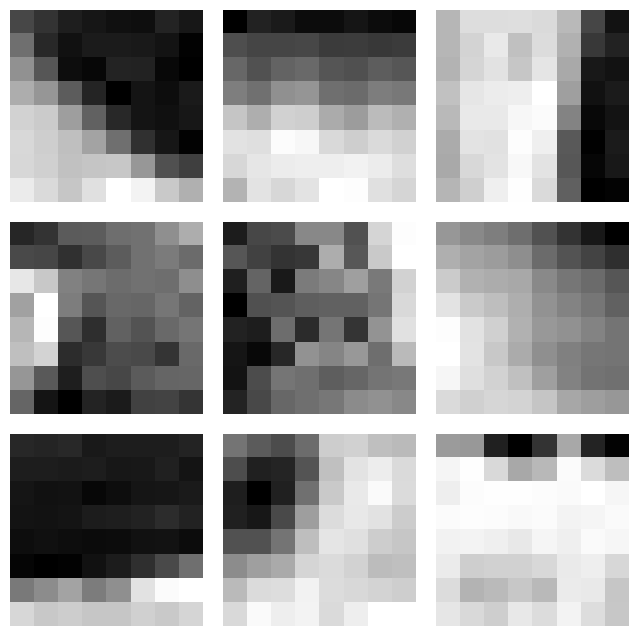

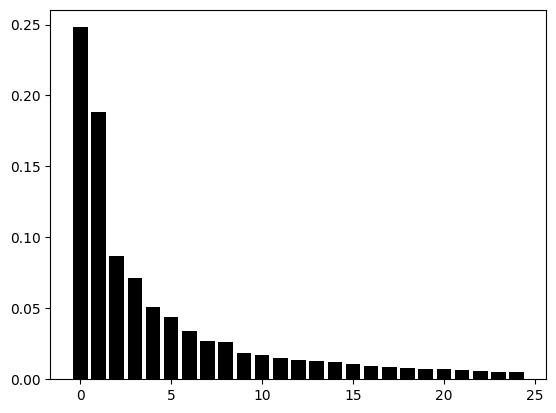

In [94]:
np.random.seed(42)

# Generate dataset
dir_name = "../data/flower_10/"
patchsize = 8
n = 500
X_img = []
for i, file in enumerate(os.listdir(dir_name)):
    img = color.rgb2gray(io.imread(dir_name+file))
    patches = extract_patches_2d(img, (patchsize, patchsize))
    patches = patches - np.mean(patches, axis=(1, 2))[:, np.newaxis, np.newaxis]  # remove DC component
    X_img.append(patches[np.random.choice(np.arange(patches.shape[0]), size=n//10, replace=False)])
X = np.concatenate(X_img, axis=0)

# Plot dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[n//10 * i], cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

# Compute BIC of PPCA and PSA models
X = X.reshape((n, patchsize*patchsize))
n, p = X.shape
eigval, eigvec = evd(X)
plt.figure()
plt.bar(np.arange(25), eigval[:25], color='k')
plt.show()
bic_psa = bic((2, 3, p - 5), eigval, n)
bic_ppca = bic((1, 1, 1, 1, 1, p - 5), eigval, n)


In [95]:
n_pcs = 5

models = [[1,1,1,1,1,p-n_pcs],
        [1,1,1,2,p-n_pcs],[1,1,2,1,p-n_pcs],[1,2,1,1,p-n_pcs],[2,1,1,1,p-n_pcs],
        [3,1,1,p-n_pcs],[2,2,1,p-n_pcs],[1,3,1,p-n_pcs],[2,1,2,p-n_pcs],[1,2,2,p-n_pcs],[1,1,3,p-n_pcs],
        [4,1,p-n_pcs],[3,2,p-n_pcs],[2,3,p-n_pcs],[1,4,p-n_pcs],
        [5,p-n_pcs]]


best_model, best_bic = model_selection(X, models, criterion="bic")

In [96]:
mu = np.mean(X, axis=0)
X_centered = X - mu
pcs = X_centered @ eigvec[:,:n_pcs]

In [97]:
fl_type = np.cumsum(best_model[:-1])

In [98]:
# the feature hierarchy 

Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [99]:
print('Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(frep))
print(np.linalg.norm(u- pcs)/np.linalg.norm(frep))
print(np.linalg.norm(q- pcs)/np.linalg.norm(frep))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Euclidean distance
7.992719052096969
8.177002032240152
8.316479319520301
Projection distance (subspace)
2.4271497941280295e-15
3.152309401814525e-15
2.345328638767809e-15
Projection distance (flag)
4.5701993989789546e-15
5.908555044529752e-15
4.5701993989789546e-15


Cats and dogs

In [122]:
n_pcs = 5

data = torch.load('../data/cats_dogs/myCATS.pt').numpy().T
p, n = data.shape


models = [[1,1,1,1,1,4096-n_pcs],
        [1,1,1,2,4096-n_pcs],[1,1,2,1,4096-n_pcs],[1,2,1,1,4096-n_pcs],[2,1,1,1,4096-n_pcs],
        [3,1,1,4096-n_pcs],[2,2,1,4096-n_pcs],[1,3,1,4096-n_pcs],[2,1,2,4096-n_pcs],[1,2,2,4096-n_pcs],[1,1,3,4096-n_pcs],
        [4,1,4096-n_pcs],[3,2,4096-n_pcs],[2,3,4096-n_pcs],[1,4,4096-n_pcs],
        [5,4096-n_pcs]]

#regular PCA
eigval, eigvec = evd(data)
baseline_weights = eigvec[:,:n_pcs]
true_fl_type, _ = model_selection_eval(data, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])

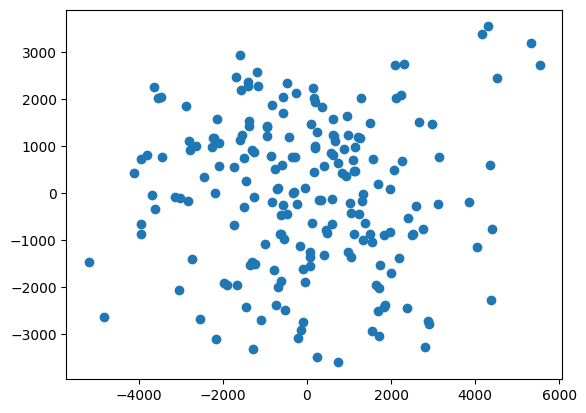

In [123]:
mu = np.mean(data, axis=0)
X_centered = data - mu
pcs = X_centered @ eigvec[:,:n_pcs]

plt.scatter(pcs[:,0],pcs[:,1])

In [102]:
Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [103]:
print('Relative Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(u- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(q- pcs)/np.linalg.norm(pcs))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Relative Euclidean distance
0.9999653859305659
0.9999653859305659
0.9999920584090141
Projection distance (subspace)
2.222111373694807e-15
2.387886018380419e-15
1.2728258020942953e-15
Projection distance (flag)
6.6435510124523684e-15
6.6435510124523684e-15
6.6435510124523684e-15


digits from https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits

In [112]:

from sklearn import datasets

In [113]:
mnist_dset = datasets.load_digits(n_class=2)

In [114]:
X = mnist_dset['data']
labels = mnist_dset['target']

In [115]:
n_pcs = 5

models = [[1,1,1,1,1,4096-n_pcs],
        [1,1,1,2,4096-n_pcs],[1,1,2,1,4096-n_pcs],[1,2,1,1,4096-n_pcs],[2,1,1,1,4096-n_pcs],
        [3,1,1,4096-n_pcs],[2,2,1,4096-n_pcs],[1,3,1,4096-n_pcs],[2,1,2,4096-n_pcs],[1,2,2,4096-n_pcs],[1,1,3,4096-n_pcs],
        [4,1,4096-n_pcs],[3,2,4096-n_pcs],[2,3,4096-n_pcs],[1,4,4096-n_pcs],
        [5,4096-n_pcs]]

#regular PCA
eigval, eigvec = evd(X)
baseline_weights = eigvec[:,:n_pcs]
true_fl_type, _ = model_selection_eval(X, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])

In [116]:
mu = np.mean(X, axis=0)
X_centered = X - mu
pcs = X_centered @ eigvec[:,:n_pcs]

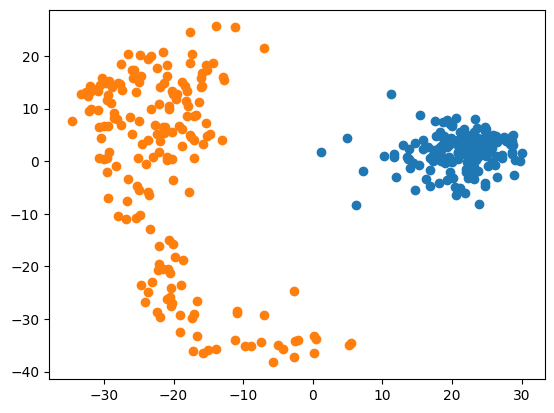

In [121]:
plt.scatter(pcs[np.where(labels == 0),0],pcs[np.where(labels == 0),1])
plt.scatter(pcs[np.where(labels == 1),0],pcs[np.where(labels == 1),1])

In [117]:
Aset = [np.arange(ssd) for ssd in fl_type]

frep, _ = FlagRep(pcs, Aset)
u,_,_ = np.linalg.svd(pcs, full_matrices=False)
q,_ = np.linalg.qr(pcs)

In [118]:
print('Relative Euclidean distance')
print(np.linalg.norm(frep- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(u- pcs)/np.linalg.norm(pcs))
print(np.linalg.norm(q- pcs)/np.linalg.norm(pcs))

print('Projection distance (subspace)')
print(np.sqrt(2)*np.linalg.norm(frep @frep.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(u @ u.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))
print(np.sqrt(2)*np.linalg.norm(q @ q.T - pcs@np.linalg.inv(pcs.T @ pcs) @pcs.T))

print('Projection distance (flag)')

frep_dist = np.sqrt(2)*np.linalg.norm(frep[:,:fl_type[0]] @frep[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
svd_dist = np.sqrt(2)*np.linalg.norm(u[:,:fl_type[0]] @ u[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
qr_dist = np.sqrt(2)*np.linalg.norm(q[:,:fl_type[0]] @ q[:,:fl_type[0]].T - pcs[:,:fl_type[0]]@np.linalg.inv(pcs[:,:fl_type[0]].T @ pcs[:,:fl_type[0]]) @pcs[:,:fl_type[0]].T)
for i in range(len(fl_type)-1):
    frep_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    svd_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)
    qr_dist += np.sqrt(2)*np.linalg.norm(q[:,fl_type[i]:fl_type[i+1]] @ q[:,fl_type[i]:fl_type[i+1]].T - pcs[:,fl_type[i]:fl_type[i+1]]@np.linalg.inv(pcs[:,fl_type[i]:fl_type[i+1]].T @ pcs[:,fl_type[i]:fl_type[i+1]]) @pcs[:,fl_type[i]:fl_type[i+1]].T)

print(frep_dist)
print(svd_dist)
print(qr_dist)

Relative Euclidean distance
0.9980284493235277
1.001982250439246
1.0014850678125395
Projection distance (subspace)
1.876666798779684e-15
2.4451181301181226e-15
1.732825774577086e-15
Projection distance (flag)
6.209002127025211e-15
6.209002127025211e-15
6.209002127025211e-15


Reproducing results ... code from https://arxiv.org/pdf/2307.15348

In [3]:
np.random.seed(42)

# Generate dataset
dir_name = "../data/flower_10/"
patchsize = 8
n = 500
X_img = []
for i, file in enumerate(os.listdir(dir_name)):
    img = color.rgb2gray(io.imread(dir_name+file))
    patches = extract_patches_2d(img, (patchsize, patchsize))
    patches = patches - np.mean(patches, axis=(1, 2))[:, np.newaxis, np.newaxis]  # remove DC component
    X_img.append(patches[np.random.choice(np.arange(patches.shape[0]), size=n//10, replace=False)])
X = np.concatenate(X_img, axis=0)

# Plot dataset
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X[n//10 * i], cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

# Compute BIC of PPCA and PSA models
X = X.reshape((n, patchsize*patchsize))
n, p = X.shape
eigval, eigvec = evd(X)
plt.figure()
plt.bar(np.arange(25), eigval[:25], color='k')
plt.show()
bic_psa = bic((2, 3, p - 5), eigval, n)
bic_ppca = bic((1, 1, 1, 1, 1, p - 5), eigval, n)


FileNotFoundError: [Errno 2] No such file or directory: '../data/flower_10/'

In [5]:
models = candidate_models_hierarchical(eigval[:10])
fl_type0, bic0 = model_selection(X, models, criterion="bic")

NameError: name 'eigval' is not defined

In [6]:
fl_type = list(np.cumsum(fl_type0).astype(int))


NameError: name 'fl_type0' is not defined

In [12]:
import pandas as pd
df = pd.read_csv('/Users/natemankovich/Documents/PostDoc/FlagManifoldsV3/results/cats_dogs.csv',index_col = 0)

<Axes: xlabel='Number of Splits', ylabel='Distance'>

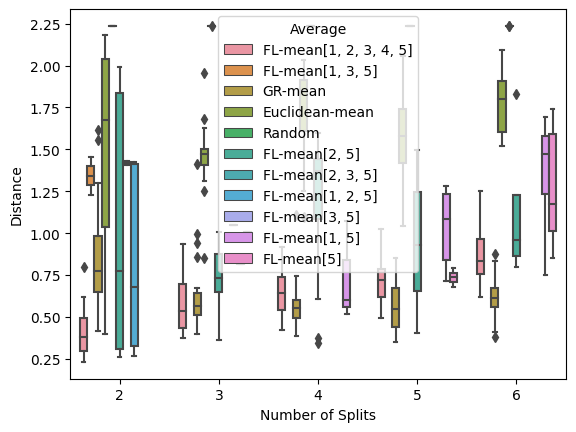

In [13]:
import seaborn as sns
sns.boxplot(x='Number of Splits', y='Distance', hue='Average', data=df)

In [4]:


plt.xlabel('Splits')
plt.ylabel('Chordal Distance')

plt.legend()

NameError: name 'n_splits' is not defined

<Figure size 640x480 with 0 Axes>

MNIST??

In [ ]:
from sklearn import datasets